In [1]:
! pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 26.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
from google.colab.patches import cv2_imshow

In [4]:
# unzip dataset from my drive
%%capture
! unzip '/content/drive/MyDrive/AFLW2000-3D.zip'

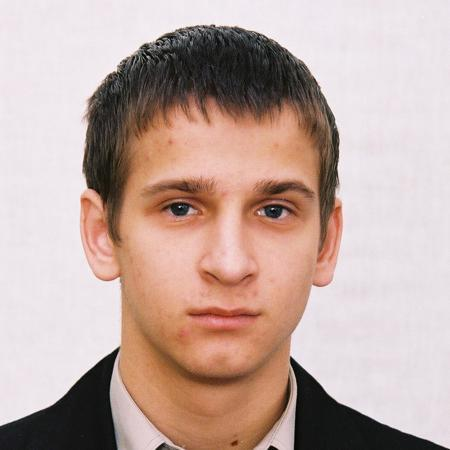

In [5]:
# read a random image
random_file = 'image00053'
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
cv2_imshow(image)

In [6]:
# function to draw axes on the image
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

## Import Dataset and extract keypoints

In [7]:
path = '/content/AFLW2000'

In [8]:
faceModule = mediapipe.solutions.face_mesh
X = []
labels = []
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
  for i in glob.glob(path + "/*.jpg"): # i = '/content/AFLW2000/image04307.jpg'
      # loading the image
      image = cv2.imread(i)
      
      # load the corresponding label
      label = mat_file = sio.loadmat(i.split('jpg')[0] + 'mat')
      
      # extracting the labels 3 angels
      pose_para = mat_file["Pose_Para"][0][:3]
      face_2d = []
      
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                # cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                
                # append all points of the face
                face_2d.append(x)
                face_2d.append(y)
        # append the sample into X
        X.append(face_2d)
        # Extract and appendlabels
        pitch = pose_para[0]
        yaw = pose_para[1]
        roll = pose_para[2] 
        labels.append([pitch, yaw, roll])

In [9]:
# convert lists to numpy arrays
X = np.array(X, dtype=np.float64)
labels = np.array(labels, dtype=np.float64)

In [10]:
X.shape

(1853, 936)

In [11]:
labels.shape

(1853, 3)

## Model Training

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# split data into 80% training set and 20% validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size=0.2, random_state=42)

In [14]:
print(X_train.shape)
print(X_valid.shape)

(1482, 936)
(371, 936)


In [15]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [16]:
# use multi output regressor to predict the 3 labels
svm = MultiOutputRegressor(SVR())
svm.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

In [17]:
print("Accuracy:", svm.score(X_train, y_train))

Accuracy: 0.8235306818360044


In [18]:
print("Accuracy:", svm.score(X_valid, y_valid))

Accuracy: 0.24293118740616884


## Extract image key points

In [19]:
# extract keypoints of a single image
def extract_keypoints(image):
  face_2d = []
  tdx, tdy = None, None

  with faceModule.FaceMesh(static_image_mode=True) as faces:
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for i,landmark in enumerate(face.landmark):
            # extract nose point
            if i == 1:
              tdx = landmark.x * shape[1]
              tdy = landmark.y * shape[0]
            
            x = landmark.x
            y = landmark.y
            # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])

            # cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            face_2d.append(x)
            face_2d.append(y)
  return face_2d, tdx, tdy
    

## Predict a random image

In [20]:
random_file = 'image00053'
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
face_2d, tdx, tdy = extract_keypoints(image)

In [21]:
np.array(face_2d).shape

(936,)

In [22]:
p = svm.predict(np.array(face_2d).reshape(1,-1))

In [23]:
p.shape

(1, 3)

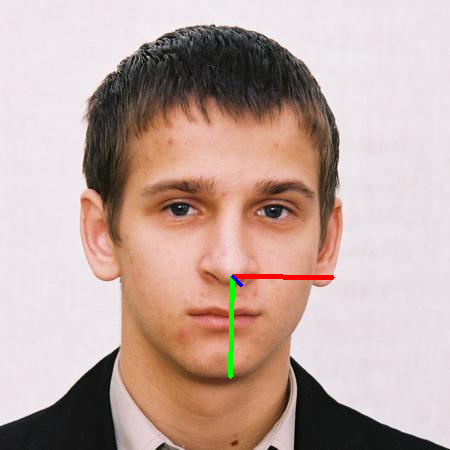

In [24]:
cv2_imshow(draw_axis(image,p[0][0], p[0][1], p[0][2], tdx, tdy))

## Predict a video

In [25]:
vid_path = '/content/boy.mp4'
# vid_path = '/content/cutegirl.mp4'
# vid_path = '/content/drive/MyDrive/Colab Notebooks/ITI/test.mp4'
# vid_path = '/content/istockphoto-1280716258-640_adpp_is.mp4'
# vid_path = '/content/WIN_20230218_23_38_42_Pro.mp4'

cap = cv2.VideoCapture(vid_path)

fwidth =  int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fheight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (fwidth,fheight))

while(cap.isOpened()):
  ret, frame = cap.read()
  # cv2_imshow(frame)

  if not ret:
    break
  # extract keypoints
  face_2d, tdx, tdy = extract_keypoints(frame)
  # print(np.array(face_2d).shape)
  # print(face_2d)

  # predict z axis
  if len(face_2d) > 0:
    p = svm.predict(np.array(face_2d).reshape(1,-1))
    # print(p)
    img = draw_axis(frame,p[0][0], p[0][1], p[0][2], tdx, tdy)
    # cv2_imshow(img)
    # write the frame to the output video
    out.write(img)
  
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

out.release()
cap.release()
cv2.destroyAllWindows()